# Lab 9-2: Feature Generation with NNs 🕸


## Learning Objectives
* Introduce the concept of feature learning, deep learning, and transfer learning.
* Use a neural network to generate features.
* Set up simple ML algorithms (k-means, k-nn, logistic regression) in `sklearn` and train them on the generated features.
* Explore the use of k-NN for image retrieval. 


## Today's Lab
In today's lab we will use a pre-trained neural network (NN) to generate features for a dataset of input images showing cats and dogs. Once we understand the NN and have generated features, then we use those to perform [image retrieval](https://en.wikipedia.org/wiki/Image_retrieval). 


## Outline
1. [Getting Set Up](#1.-Getting-Set-Up)
    1. [Problem Understanding: Feature Generation with Neural Networks](#Problem-Understanding:-Feature-Generation-with-Neural-Networks)
    2. [Preparing Our Data](#Preparing-Our-Data)
2. [The Pre-Trained Model (Step 1)](#2.-The-Pre-Trained-Model-(Step-1))
    1. [Getting and Understanding the Pre-Trained NN](#Getting-and-Understanding-the-Pre-Trained-NN)
    2. [Setting up the Feature Generator](#Setting-up-the-Feature-Generator)
3. [Generating Features (Step 2)](#3.-Generating-Features-(Step-2))
    1. [Preprocessing an Image](#Preprocessing-an-Image)
    2. [Using Our Model to Generate Features](#Using-Our-Model-to-Generate-Features)
4. [Using the Extracted Features (Step 3)](#4.-Using-the-Extracted-Features-(Step-3))
    1. [Use Case I: A Simple Check and Visualization with k-Means](#-Use-Case-I:-A-Simple-Check-and-Visualization-with-k-Means)
    2. [Use Case II: Building a Retrieval System](#-Use-Case-II:-Building-a-Retrieval-System)
    3. [[optional] Use Case III: Training and Evaluating a Linear Model](#[optional]-Use-Case-III:-Training-and-Evaluating-a-Linear-Model)

## 1. Getting Set Up

### Problem Understanding: Feature Generation with Neural Networks

To understand this process (and our entire lab today), it it importnat to **view neural networks as a combination of feature generators and prediction model**. In fact, the _very last layer_, also referred to as _output layer_, is often a (mulit-class) logistic regression model (or a linear regression model). In turn the other layers between input and output layer can be seen as various feature represtations, morphing from lower level to higher-levelo features as the information is passed trhough the network. The basic idea is that the lower level (or "earlier" layers) correspond to more general features nad later layers correspond to more specific features. For images, these features can be *edges*, *colors*, and *textures*, then slightly more complex features such as *ears* and *eyes* later on very complex concepts like *faces* or entire *bodies*.

Now, when we train a neural network, you can view this step as learning feature representations as well as model parameters for your classifier (or regresion model) _simultaneously_. Now, you can imagine why we need so many traning examples. Also, it should be easy to acknolwedge now that traning the classifier only is much easier and in turn should need less traning data. So, our idea here is to decouple the feature leanring and the classification part.   

Instead of training the neural naetwork base, we can take a pre-trained network, and the data representations it learned, and use it to generate features for our dataset. Then, we can use this new feature representation of our data to train a simple classifier, like the ones we already studied such as kNN or linear classifier. This concept is also knows as *transfer learning*.

This is helpful because we can save the **time** and/or **large amounts of data needed** to successfully train our own network end-to-end. 

The image below illustrates this process, from left to right: 
* **Step 1**: train a neural network classifier on any **large enough** dataset (or find a pre-trained NN)
* **Step 2**: take your dataset (which has the same features/image dimensions) and plug in the features/input into the (pre-)trained NN to compute the new features (no predicion happens here)
* **Step 3**: use those new features along with the targets to train a classifier (using any model) and use it for predictions

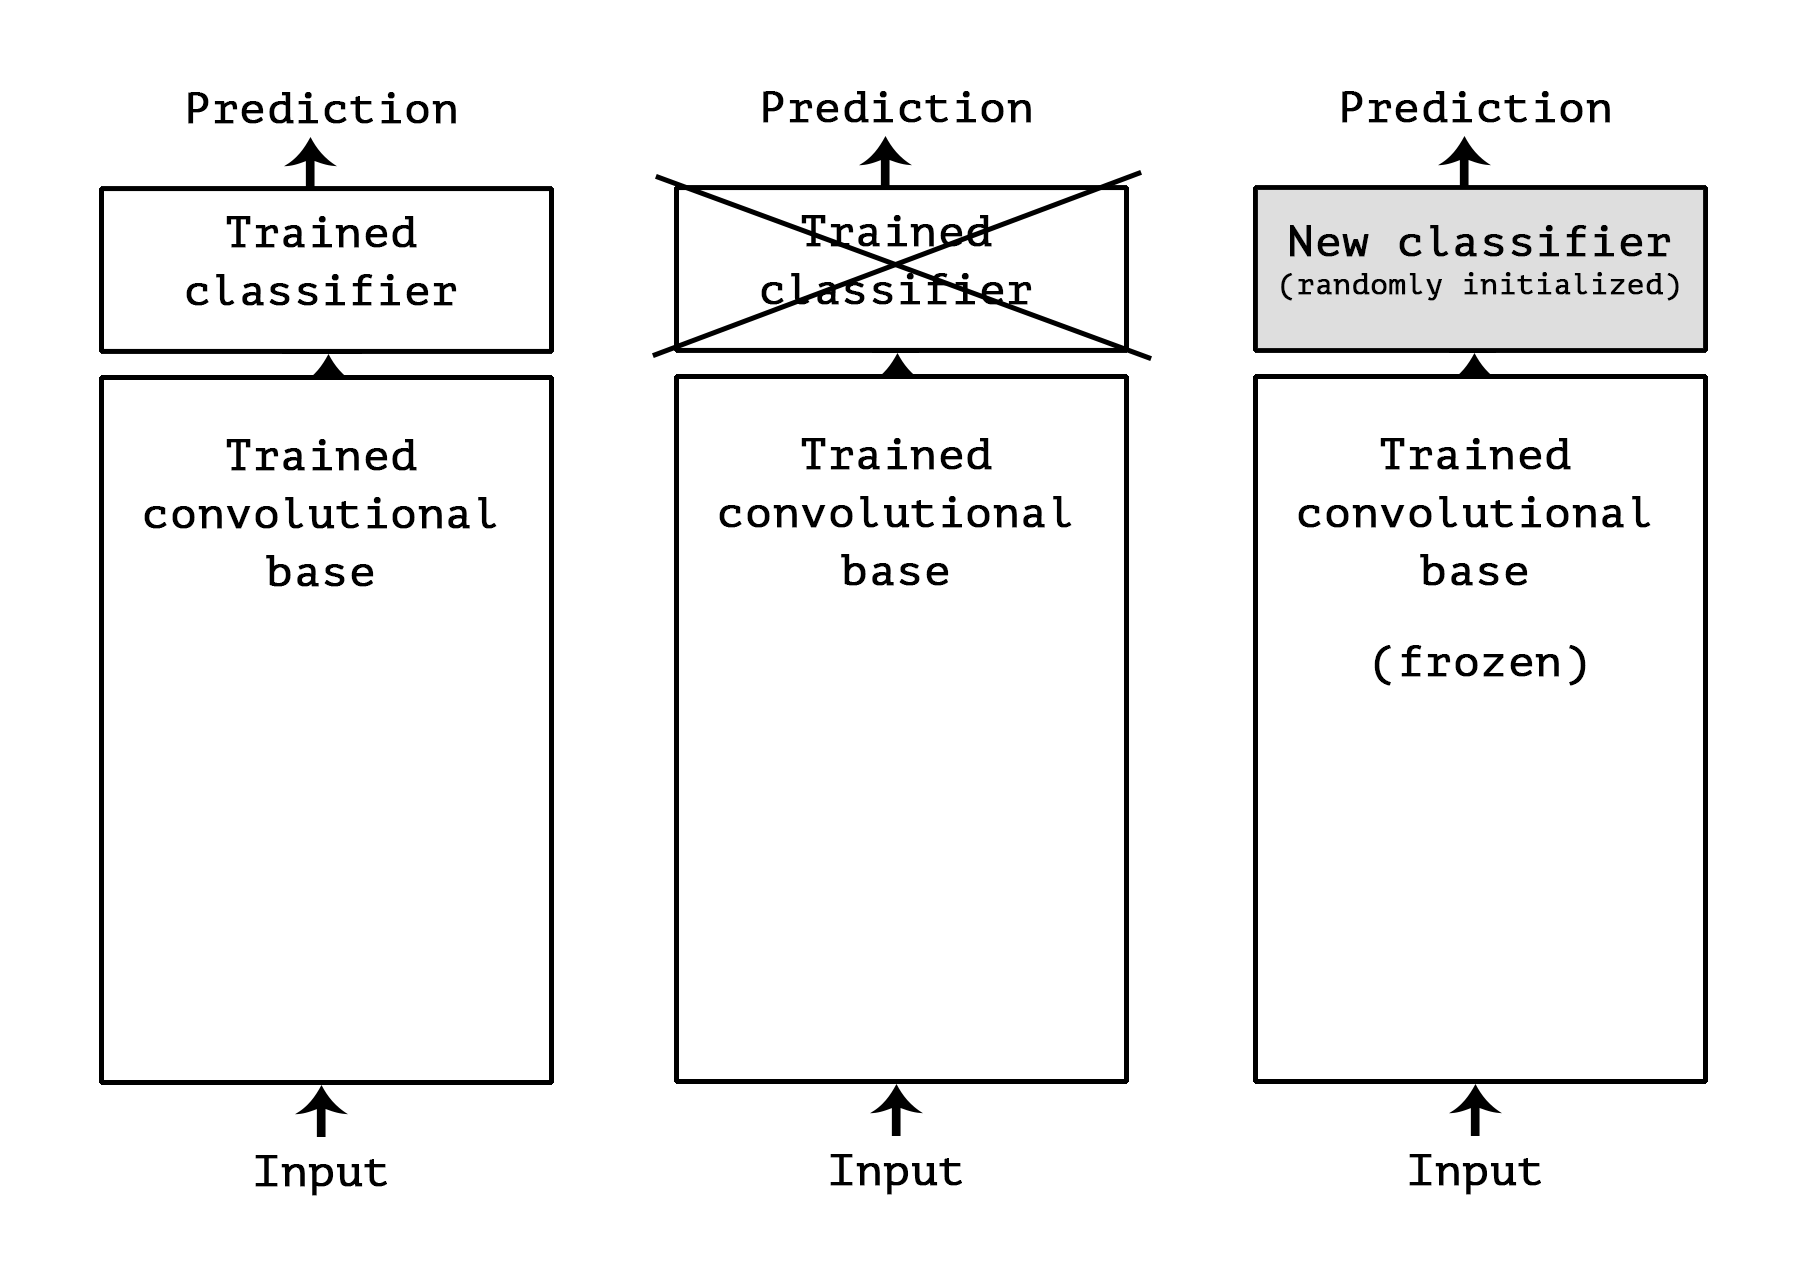(from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

The real link: [https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb)

### Preparing Our Data

We assume that you have a working installation of TensorFlow, as well as a downloaded version of the dataset in your Downloads folder. If not, follow the intructions on the Canvas page or Piazza post on Lab9-2 Setup. 

#### Command line 
**Do this!** The first thing you will want to do is to extract the dataset (if zipped) and **move** the `PetImages` directory of the data into the `utility/data` directory of this lab.

> **Caution:** Do not _copy_ the dataset, since that will take a long time and take up unnecessary resource on your machine. Do **not** use the jupyter browser as a file system browser. It's best to use the `command line`. If you need a reminder on how to move a dataset, follow the commandline instructions provided [here](https://wustl.instructure.com/courses/76409/pages/command-line-and-git?module_item_id=1078359). 


After completing this step outside of you nteobook, run the following cell to double-check: 

In [6]:
from os import listdir
import numpy as np

base_dir = 'utility/data'

assert 'PetImages' in listdir(base_dir), f'Couldn\'t find `PetImages` in the `{base_dir}` directory of this lab'

Let's also get some basic stats for our dataset and set up some variables. Find out how many classes there are and how many examples there are in each class. 

> **Hint**: You may just click around a file explorer to solve this, or consider using command line tools like `ls` (list folder contents) and `wc` (stands for wordcount). You can even use the following command line magic: `ls path2folder_you_want_to_count_the_conent_for | wc -l`

The pipe `|` pipes the output of one command into the next command and the `-l` flag stans for lines (instead of getting word or character counts). 

#### Notebook

**Try this!** In the cell below, store the names of the classes (their directory names) as a list called `classes`. Then, store the number of examples in each class in a list called `counts` such that the indicies of the counts match the indicies in `classes`.

In [7]:
# your code here 
classes = ["Cat", "Dog"]
counts = [12501, 12501]

Now, let's take a look at what each example looks like. To make this fun, let's sample a random image. Note that we will also use this function later on. 

**Try this!** Using the `classes` and `counts` lists that you defined earlier, complete the `get_random_image` function so that it 
* if `num_samples=1`: randomly returns an index for an image in the `target_class` and stores it as `index`. 
* else: randomly provides `num_samples` **unique** ids for images in the folder of `target_class` images. 

> **Hint:** `np.random.choice` can be used in both cases, however, it's a little tricky to get configured correctly. `np.random.randint` and `np.random.permutation` are easier to set up.

In [17]:
def get_random_image(base_dir, classes, counts, target_class=None, num_samples=1):
    '''
    Returns the path of a randomly chosen image from TARGET_CLASS
    or a randomly selected class given the CLASSES and COUNTS
    '''
    
    # choose class randmoly if not provided
    if not target_class:
        target_class = np.random.choice(classes)
    
    target_idx = classes.index(target_class)
    if num_samples==1: 
        
        # your code here
        index = np.random.randint(0, counts[target_idx])
        
    else:
        # your code here 
        index = np.random.permutation(counts[target_idx])[0:num_samples]
        
    return index

assert np.unique(get_random_image(base_dir, classes, counts, classes[1], counts[1])).shape[0]==counts[1], \
                    'It looks like you did NOT sample *unique* ids.'

Let's look at some random images of both, cats and dogs. ..._enjoy!_...

Evaluate the following cell multiple times to make sure your implementation works as expected: *random*!

Random Cat:


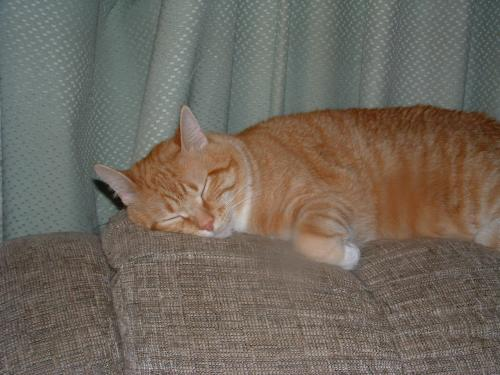

Random Dog:


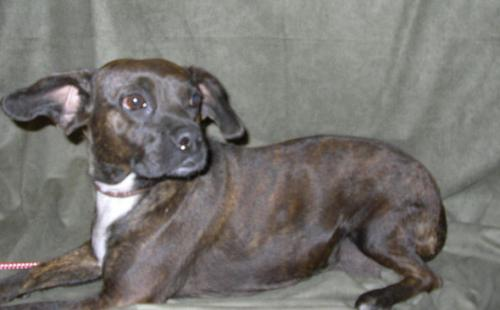

In [34]:
import numpy as np
from IPython.display import Image

for pet in classes:
    id = get_random_image(base_dir, classes, counts, pet)
    image = Image(filename=f"{base_dir}/PetImages/{pet}/{id}.jpg")
    print("Random "+pet+":")
    display(image)

## 2. The Pre-Trained Model (Step 1)
### Getting and Understanding the Pre-Trained NN 

From the various pre-trained models that `Keras` has available we will be using [VGG16](https://neurohive.io/en/popular-networks/vgg16/).

**Write-up** Describe the data set that was used to train VGG-16. How long did it take to train the network? 

**Your response here:** It was trained using downsampled labeled images from ImageNet, which contains millions of labeled images in different categories. It took weeks to train.


This is how the data looks like as it is being processed by the network: 

![VGG16](utility/pics/VGG16.png)

Let's load it up and take a look:

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16

full_model = VGG16(weights='imagenet')
full_model.summary()

553467904/553467096 [==============================] - 22s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

**Write-up!** What is the size of the input images? How many layers and parameters are there in this model? 
> **Self check:** `True` or `False`: The dimensionality of inputs to the layers gets smaller as the data moves through the network.

**Your response here:** They are 224x224x3. There are 138,357,544 parameters with 23 layers.


### Setting up the Feature Generator
Now, we can decide _which_ features to use. The next cell shows you how to set up the model to generate features from  a specific layer of the network specified by the layer name. 

**Try this!** Create a model that will generate features using the **last layer that is _not_ dense**; store it in `extractor_model`.

In [36]:
from tensorflow.keras.models import Model

## set up model to get *any specific layer* as features
base_model = VGG16(weights='imagenet')


# Example: block3 layer
layer_name = 'block3_conv2'  
extractor_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)


# set up model to get *last layer before fully connected layer* as features
# your code here 

layer_name2 = 'flatten'  
extractor_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name2).output)


extractor_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## 3. Generating Features (Step 2)

### Preprocessing an Image 

Now that we have loaded the model, let's take a look at an example of the input that it takes. In the cell below, we use the `get_random_image` function to get the path of a randomly chosen image of a cat — _'cuz cats are better_ (?!).

In [37]:
id = get_random_image(base_dir, classes, counts, 'Cat')
path = f'{base_dir}/PetImages/Cat/{id}.jpg'
path

'utility/data/PetImages/Cat/11014.jpg'

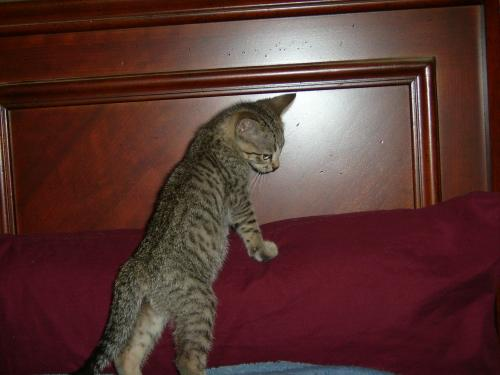

In [38]:
from IPython.display import Image

display(Image(filename=path))

Next, let's implement a function that loads the image from its path and preprocesses it.

In [42]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(path, target_size=(224, 224)):
    '''
    Takes an image path and returns a preprocessed version of it.
    '''
    img = image.load_img(path, target_size=target_size)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    return preprocess_input(img_data)

In [45]:
processed = preprocess_image(path)

array([[[[ -69.939,  -63.779,  -62.68 ],
         [ -69.939,  -63.779,  -62.68 ],
         [ -71.939,  -66.779,  -62.68 ],
         ...,
         [-103.939, -109.779,  -79.68 ],
         [-103.939, -103.779,  -77.68 ],
         [-103.939, -102.779,  -77.68 ]],

        [[ -92.939,  -88.779,  -82.68 ],
         [ -95.939,  -92.779,  -83.68 ],
         [ -99.939,  -96.779,  -87.68 ],
         ...,
         [-103.939, -108.779,  -78.68 ],
         [-103.939, -107.779,  -76.68 ],
         [-103.939, -106.779,  -77.68 ]],

        [[-103.939, -103.779,  -87.68 ],
         [-103.939, -102.779,  -86.68 ],
         [-103.939, -104.779,  -85.68 ],
         ...,
         [-103.939, -108.779,  -78.68 ],
         [ -99.939, -107.779,  -69.68 ],
         [-102.939, -109.779,  -73.68 ]],

        ...,

        [[ -92.939, -107.779,  -92.68 ],
         [ -92.939, -107.779,  -92.68 ],
         [ -92.939, -108.779,  -90.68 ],
         ...,
         [ -88.939, -106.779,  -82.68 ],
         [ -87.939, -1

**Write-up** What does the previous cell do? Why do we we need to preprocess the input to our extractor model?

**Your response here:** It's resizing and converting the image into an array.


### Using Our Model to Generate Features

We can now use our model to extract some features for us to use later.

In [41]:
feature = extractor_model.predict(processed)
assert feature.size==25088, f'You are not using the correct layer to generate the features. Check your implementation under 3.2 setting up the Feature Generator'

feature.shape

(1, 25088)

**Write-up!** Describe the shape of the feature produced by the model.

**Your response here:** (1, 25088).


Next, we will extract the features of the random images of 200 cats and 200 dogs and transform them into a shape that we can use for our classifier. 

**Try this!** In the following cell, complete the code below that extracts the features of 200 random images of each cats and dogs (**400 total**). Start by preprocessing the images, then geenrate the feautres using our NN. After the feautes are generated, you will need to transform them into a `np.array` and make sure they are in the shape of a *vector* (1d-array). Collect each vector in `vgg16_features` in the same order as their corresponding image path in `image_paths`. To test and debug your implementation we use a small number of images first (`num_cats_dogs = 5`), remeber to set this to the correct number once, your code works.


> **Hints**: Make use of the `preprocess_image` function that we implemented before. Make sure your extracted features are in the shape of a vector. This might be useful: [`flatten` 🔗](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html).

In [46]:
image_paths = []
vgg16_features = []
num_cats_dogs=200

for pet in classes:
    
    # sample images from under the directory 'Dog' or 'Cat' (+10 to have a buffer to account for some invalid images)
    path_ids = get_random_image(base_dir, classes, counts, pet, num_samples=num_cats_dogs+10)   
    
    print(f'[{pet}]')
    i,j = 0,0
    while i<num_cats_dogs:
        
        # a simple progress bar
        print('.', end='')
        if not (i + 1) % 50:
            print(i + 1)
            
        path = f'{base_dir}/PetImages/{pet}/{path_ids[j]}.jpg'
        j=j+1
        
        # in case we try to load an invalid image, we can take the next one 
        try: 
            # your code here 

            image_paths.append(path)
            i=i+1
        except:
            print("Something is wrong with this image: "+path)


labels = np.concatenate((np.zeros(num_cats_dogs), np.ones(num_cats_dogs)))
features = np.array(vgg16_features)

[Cat]
..................................................50
..................................................100
..................................................150
..................................................200
[Dog]
..................................................50
..................................................100
..................................................150
..................................................200


In [47]:
print(labels.shape)
print(features.shape)

(400,)
(0,)


**Write-up** What class label do we use for `Dog` and `Cat` respectively? How many data points do we have, how many features? 

**Your response here:** 


## 4. Using the Extracted Features (Step 3) 

### Use Case I: Simple Check and Visualization with _k_-Means

Now, we can do various things with these new features: use them to train a new classifier (we will do this in `hw9`), cluster them, build a retrieval system, or even use them to generate yet another set of new features. Carzy! First, we will use a _k_-means algorithm (from `Lab7`/`hw7`) with two clusters to see whether the generated features can successfully distinguish between cat and dog images.

**Try this!** Create and fit a new `KMeans` model with two clusters using the new training features that we extracted. Configure your model to use a `random_state` of 4. Store the cluster assignments in `assignments` and the fit centroids in `centroids`.

In [ ]:
from sklearn.cluster import KMeans

# your code here 


assert assignments.shape[0]==400, f'You are not using the correct amount of data to fit the model. Hint: check num_cats_dogs above.'
assert model.n_features_in_==25088, f'You are not using the features generated from VGG16 to fit the model.'

assignments

If our newly generated features were completely accurate, the assignments of the first half of the points would be in one cluster the second half in the other cluster.


To visualize the generated features, the clusters, and the class labes, we will calculate the _cosine distance_ of the generated features of each image to the **centers of the _two_ clusters**. This resutls in a new 2-dimensional feature that we can then plot alongside with the cluster assignments. The [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) essentially represents $1-$ the size of the angle between lines going from the origin to the two points represented by their feature vectors. This can be geometrically represented in 2D, but the same concept holds for higher dimensions. 

In [ ]:
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt

from utility.util import configure_plots

configure_plots()
#plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
configure_plots()

In [ ]:
c1_dists = []
c2_dists = []

for x in range(0, features.shape[0]):
    c1_dists.append(dist.cosine(features[x], centroids[0]))
    c2_dists.append(dist.cosine(features[x], centroids[1]))

c1_dists = np.asarray(c1_dists)  
c2_dists = np.asarray(c2_dists)  
plt.xlabel('distance to cluster 1')
plt.ylabel('distance to cluster 2')


plt.scatter(c1_dists[labels==0], c2_dists[labels==0], c=assignments[labels==0], cmap='rainbow', marker=r'$cat$', s=400, label="true class is cat")
plt.scatter(c1_dists[labels==1], c2_dists[labels==1], c=assignments[labels==1], cmap='rainbow',  marker=r'$dog$', s=400, label="true class is dog")

plt.title("Colors represent cluster assignments")
plt.legend()

plt.show()

**Write-up** Describe what you see in this visualization. Are the clusters themselves a good way of classifiying images in cats and dogs? If not, does this visualization spark an idea on how to use this new view on the data to create extremely low-dimensional features to be used in a simple classifier?

**Your response here:** 


### Use Case II: Building a Retrieval System

Finally, let's use our generated features to perform image retrieval. We can choose an image and find others that are similar to it, using nearest neighbors. This is called a retrieval system. 


**Try this!** In the cell below, create a new `NearestNeighbors` model configured to compute the six closest images and then fit it with the features we extracted from VGG16.

In [ ]:
from sklearn.neighbors import NearestNeighbors

# your code here 


assert kNN_model.n_neighbors==6, f'You are not using the correct number of neighbors.'
assert kNN_model.n_samples_fit_==400, f'You are not using the correct amount of data to fit the model.'
assert features.shape[1]==25088, f'You are not using the features generated from VGG16 to fit the model.'

Now let's try and see how good this model is on images it hasn't seen.

**Try this!** Find an image of a cat or a dog that you like (maybe of of your own pet or from the internet) and save it to `utility/data`. Then store the path to the image in `selected_image_path` in the cell below.

In [ ]:
# your code here 


display(Image(selected_image_path))

**Try this!** Repeat the feature extraction process from earlier on this image. Remeber to bring the features in _vector_ shape (if they are not already). With these features, use the `NearestNeighbors` model that we fit to retrieve the six most similar image indices and store these indicies in  `nearest_images`.
> **Hint**: type `model.` and then hit the `tab` key so see what functions are available for the kNN-model. 

In [ ]:
# your code here 


Let's see which images were the most similar. To do this, we will need to pull out the paths for the matching indices from `image_paths`.

In [ ]:
from IPython.display import Image

for index in nearest_images.flatten():
    print(image_paths[index])
    img = Image(filename=image_paths[index])
    display(img)

As you can see, there are some clear similarities in these pictures, but there might also be some differences as well. Feel free to speculate what might cause this!

### [optional] Use Case III: Training and Evaluating a Linear Model

Now, if you're still into it, we can do the machine learning part. 

#### Train-Test Split
The first thing we will need to do is to create a train/test split of our data set.

**Try this!** In the cell below, create a train/test split of our data set with a test set proportion of `0.25` and a `random_state` of `8`. Additionally, stratify your split with the labels you produced earlier. Finally, also refer to [this StackOverflow answer](https://stackoverflow.com/a/35622967) to get the indices of each point in the training and test sets in the original data; store these as `idx_train` and `idx_test`.

In [ ]:
# your code here 


#### Train and Evaluate The Model
Now, let's build the Logistic Regression classifier with our extracted featureset.

**Try this!** In the cell below, create a new `LogisticRegression` model with the `liblinear` solver and `random_state=11` and fit it on the training set. Then, evaluate the model on _both_ the training and testing sets. Store these in `training_acc` and `testing_acc`.

In [ ]:
from sklearn.linear_model import LogisticRegression


def print_accs(X_train, y_train, X_test, y_test):

    # your code here 


    print(training_acc)
    print(testing_acc)
    

print(features.shape)    
print_accs(X_train, y_train, X_test, y_test)

**Write-up** What were the training and testing accuracies for this model? What do each of these values mean? What do they tell us about our model?

**Your response here:** 


#### Train and Evaluate The Model on the Cluster Center Distance Features

This is another cool thing about clustering. We can use the distance to the cluster centers as features to train the linear classifier. This way we only have a 2-dimensional model instead of a 25088-diemnsional model!!! 

In [ ]:
dist_features = np.vstack((c1_dists,c2_dists)).transpose()

X_dist_train, X_dist_test, y_train, y_test, idx_train, idx_test = \
    train_test_split(dist_features, labels, np.arange(labels.shape[0]), test_size=0.25,
                     random_state=8, stratify=labels)

print(dist_features.shape)
print_accs(X_dist_train, y_train, X_dist_test, y_test)

### Awesome!!!!!!!!!!

![nice](https://media1.tenor.com/images/2acd46917cbfeca0d71d1fd0899f992f/tenor.gif?itemid=4572252)

#### Visual Inspection of Test Predictions (The Fun Part)

Now that we have trained and evaluated our model, let's get to the fun part: looking at pictures of cats and dogs!

**Try this!** Use the `choice` function provided below with _different_ random seeds to get the feature vectors of five sample images from our testing set. This fucntion returns the indices of these images in `image_indices`.

Then, use the Logistic regression model we trained in above to classify each of the images, reporting both the class label, $\hat y$, and the probability of that class, $P(y = \hat y \mid x)$. 

> **Hint:** if you need a reminder on how to get probabilities from the logistic regression model, use `model.`+`tab key` to see all available functions. One of them will do the trick! 

In [ ]:
random_seed = 14
image_indices = np.random.RandomState(seed=random_seed).choice(np.arange(X_test.shape[0]), 5)

model = LogisticRegression(solver='liblinear', random_state=11)
model.fit(X_train, y_train)

# your code here 


# print the info
for label, probability in zip(predicted_labels, probabilities):
    print(f'label={label}, probability={probability[int(label)]:0.2f}')

Let's check how our model did.

**Do this!** Use the `show_image` function to display each image in `image_indices`.

In [ ]:
from utility.util import show_image


for index in image_indices:
    path = image_paths[idx_test[index]]
    show_image(path)

Okay. That's it. Thanks for sticking around. 